In [1]:
import numpy as np
from numpy import genfromtxt
import csv
import os

import pysindy as ps

import deepSI
from deepSI import System_data

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\code\data\\"

WIENER = "WienerHammerBenchmark"
SILVER = "SNLS80mV"
# SILVER = "Schroeder80mV"
# change data set
DATA = SILVER
CSV = ".csv"

PATH = os.path.join(DATA_PATH, DATA+CSV)

# load data
data = genfromtxt(PATH, delimiter=",")

In [3]:
data = data[1:,:-1] # snl
# data = data[1:,2:-1] # schroeder

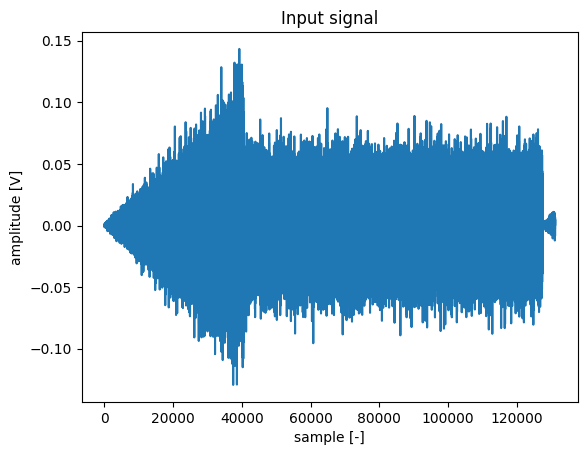

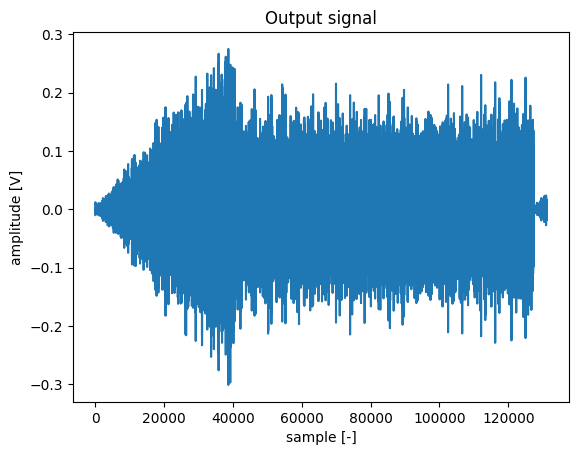

In [4]:
# data
V1 = data[:,0]
V2 = data[:,1]

N = V1.shape[0]
fs = 610.35
dt = 1/fs
t = np.linspace(0,dt*N,N)

plt.plot(V1-np.mean(V1))
plt.xlabel("sample [-]")
plt.ylabel("amplitude [V]")
plt.title("Input signal")
plt.show()

plt.plot(V2-np.mean(V2))
plt.xlabel("sample [-]")
plt.ylabel("amplitude [V]")
plt.title("Output signal")
plt.show()

In [5]:
arrow_head_idx = [i for i in range(0,40000)]
train_idx = [i for i in range(40600,V1.shape[0])]

In [6]:
silver_data = System_data(u=V1[train_idx],y=V2[train_idx])

train, test = silver_data.train_test_split(split_fraction=0.2)
print("Training samples: ", train.y.shape[0])
print("Test samples: ", test.y.shape[0])

time = t[0:train.y.shape[0]]

Training samples:  72377
Test samples:  18095


In [7]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

In [8]:
# differentiation_method = ps.SINDyDerivative(kind="spline", s=1e-2)
differentiation_method = ps.FiniteDifference(order=4)

x_train = np.stack((train.y, differentiation_method(train.y)), axis=-1)

# model specs
feature_library = ps.ConcatLibrary([ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

stlsq_optimizer = ps.STLSQ(verbose=True)#, threshold= 0.03

model = ps.SINDy(feature_library=feature_library,
                 optimizer=stlsq_optimizer,
                 discrete_time=True
                 )
# fit
model.fit(x_train, u=train.u, t=dt)
model.print()
model.coefficients()

x_test = np.stack((test.y, differentiation_method(test.y)), axis=-1)
x_dot_test_predicted = model.predict(x_test, u=test.u)

x_dot_test_simulated = model.simulate(x_test[0], u=test.u, t=test.u.shape[0])

pred_NRMS = NRMS( x_dot_test_predicted[:-1,0], test.y[1:])
simo_NRMS = NRMS( x_dot_test_simulated[:,0], test.y[:])

print("NRMS pred 1: ",pred_NRMS)
print("NRMS simo 1: ",simo_NRMS)

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.9912e+00 ... 1.1433e-01 ...          8 ... 2.1055e+00
         1 ... 1.9690e+00 ... 1.1375e-01 ...          8 ... 2.0827e+00
(x0)[k+1] = 0.764 x0[k] + 0.892 x1[k] + 0.201 u0[k] + -0.797 x0[k]^3
(x1)[k+1] = -0.443 x0[k] + 0.691 x1[k] + 0.314 u0[k] + -1.407 x0[k]^3
NRMS pred 1:  0.03033290896897965
NRMS simo 1:  0.3964527707250635


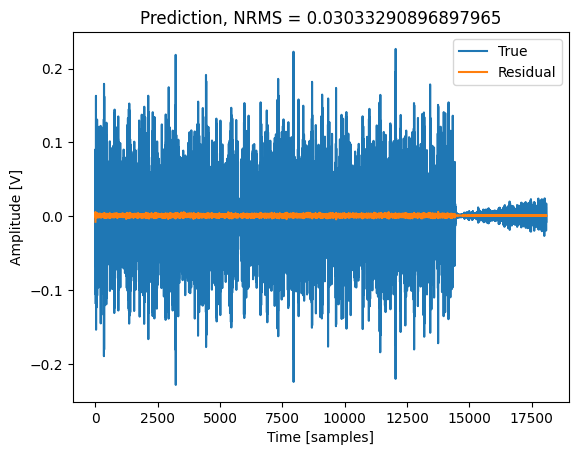

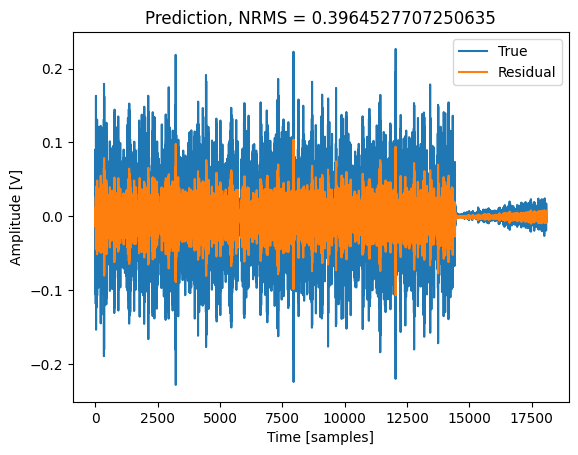

In [9]:
plt.plot(test.y)
plt.plot(x_dot_test_predicted[:-1,0]-test.y[1:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(test.y)
plt.plot(x_dot_test_simulated[:,0]-np.mean(x_dot_test_simulated[:,0])-test.y[:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()

In [10]:
arrow_head_data = System_data(u=V1[arrow_head_idx],y=V2[arrow_head_idx])
train, test = arrow_head_data.train_test_split(split_fraction=1.0)
print("Training samples: ", train.y.shape[0])
print("Test samples: ", test.y.shape[0])

x_test = np.stack((test.y, differentiation_method(test.y)), axis=-1)

x_dot_test_predicted = model.predict(x_test, u=test.u)
x_dot_test_simulated = model.simulate(x_test[0], u=test.u, t=test.u.shape[0])

pred_NRMS = NRMS( x_dot_test_predicted[:-1,0], test.y[1:])
simo_NRMS = NRMS( x_dot_test_simulated[:,0], test.y[:])

print("NRMS pred 1: ",pred_NRMS)
print("NRMS simo 1: ",simo_NRMS)

Training samples:  0
Test samples:  40000
NRMS pred 1:  0.029797865154279027
NRMS simo 1:  0.42327620007883193


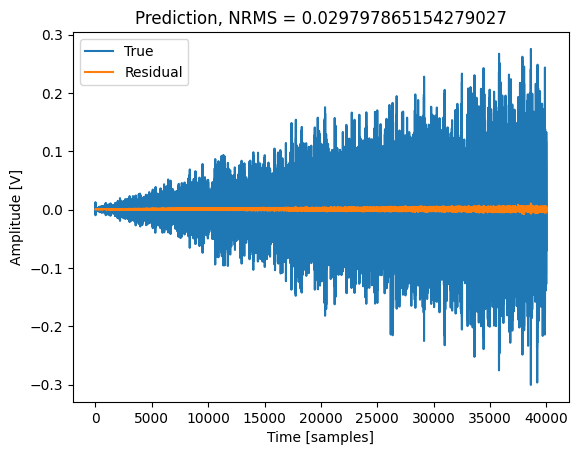

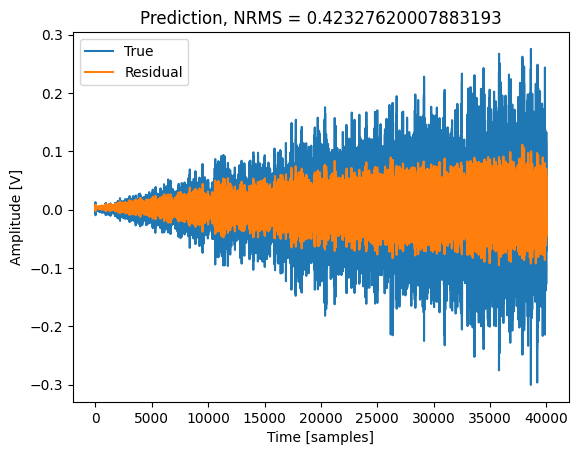

In [11]:
plt.plot(test.y)
plt.plot(x_dot_test_predicted[:-1,0]-test.y[1:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(test.y)
plt.plot(x_dot_test_simulated[1:,0]-test.y[:-1])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()

In [ ]:
from scipy.integrate import odeint

In [58]:
y = test.y
dy = differentiation_method(test.y)
y0 = [y[0], dy[0]]  # random inital state for x2
u = test.u
samples = y.shape[0]


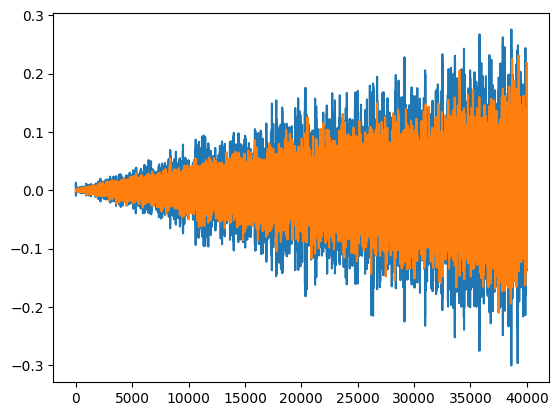

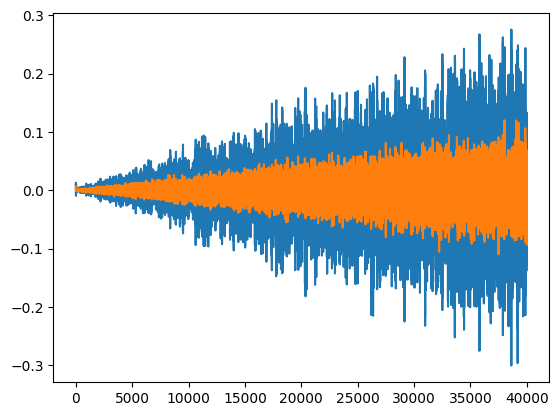

In [70]:
# initialize system's parameters
a1 = 10  #-0.764  # 0.443
a2 = 10  #-0.892  #-0.691
a3 = 10  # 0.797  # 1.407
b1 = 20  # 0.201  # 0.314

k = np.arange(0,samples,1)

def u_control(k):
    return u[int(k)]

def silverbox(x, k):
    x1 = x[0]
    x2 = x[1]
    dx1 = x2
    dx2 = -a1*x2 -a2*x1 -a3*x1**3+b1*u_control(k)
    return [dx1, dx2]

# y0 is our initial state
s = odeint(silverbox, y0=y0, t=k)

# s is a Nx3 matrix with N timesteps
# plt.plot(s[:,0])
# plt.show()
# plt.plot(s[:,1])
# plt.show()

# plt.plot(y)
# plt.plot(s[:,0]-y)
# plt.show()

# plt.plot(y)
# plt.plot(s[:,1]-y)
# plt.show()

plt.plot(y[:])
plt.plot(s[1:,0]-np.mean(s[1:,0]))
plt.show()
plt.plot(y[:])
plt.plot(s[:,1])
plt.show()